# SKKU 2025 Quantum Challenge 
## Traveling Salesman Problem

Writer: Sangyoon Woo

In [1]:
import numpy as np
import sympy as sp
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from collections import Counter
import matplotlib.pyplot as plt
import itertools
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Part 1: Leg-variable encoding of the TSP

#### 1-a)

In the leg variable encoding, $Obj = D + \lambda P$ is used to distinguish between valid and invalid tours.  

For a valid tour, all the constraints are satisfied, so the value of $P$ must be 0. Therefore, an appropriate value of $\lambda$ should be chosen.  

The goal of Problem 1-a is to find the minimum integer value of $\lambda$ that clearly separates valid tours from invalid ones.  

Although examining all possible cases could be one approach, it is highly inefficient. Instead, a simple filtering criterion is applied to identify a suitable value of $\lambda$.  

The filtering condition used here is as follows:  
$$P > 0 \; \text{and} \; D+P \le 7$$


In [2]:
d = [1, 1, 1, 2, 3, 1]

city_legs = {
    'A': [0, 1, 2],
    'B': [0, 3, 4],
    'C': [1, 3, 5],
    'D': [2, 4, 5]
}

for bits in itertools.product([0, 1], repeat=6):
    x = list(bits)
    D = sum(d[i] * x[i] for i in range(6))
    P = sum((sum(x[i] for i in city_legs[c]) - 2)**2 for c in city_legs)
    if P>0 and D+P <= 7:
        print(f'x={x}, D={D}, P={P}, D+P={D+P}')


x=[0, 0, 1, 1, 0, 0], D=3, P=4, D+P=7
x=[0, 0, 1, 1, 0, 1], D=4, P=2, D+P=6
x=[0, 1, 0, 0, 1, 1], D=5, P=2, D+P=7
x=[0, 1, 1, 0, 0, 1], D=3, P=4, D+P=7
x=[0, 1, 1, 0, 1, 0], D=5, P=2, D+P=7
x=[0, 1, 1, 1, 0, 0], D=4, P=2, D+P=6
x=[0, 1, 1, 1, 0, 1], D=5, P=2, D+P=7
x=[1, 0, 0, 0, 0, 1], D=2, P=4, D+P=6
x=[1, 0, 0, 0, 1, 1], D=5, P=2, D+P=7
x=[1, 0, 0, 1, 0, 1], D=4, P=2, D+P=6
x=[1, 0, 1, 0, 0, 1], D=3, P=2, D+P=5
x=[1, 0, 1, 1, 0, 0], D=4, P=2, D+P=6
x=[1, 1, 0, 0, 0, 1], D=3, P=2, D+P=5
x=[1, 1, 0, 0, 1, 0], D=5, P=2, D+P=7
x=[1, 1, 0, 1, 0, 1], D=5, P=2, D+P=7
x=[1, 1, 1, 0, 0, 0], D=3, P=4, D+P=7
x=[1, 1, 1, 0, 0, 1], D=4, P=2, D+P=6
x=[1, 1, 1, 1, 0, 0], D=5, P=2, D+P=7


Among these, we take a closer look at the cases where $D + P = 5$.  

Such cases include $x = [1, 0, 1, 0, 0, 1]$ and $x = [1, 1, 0, 0, 0, 1]$.  
When $\lambda = 2$, the $Obj$ value for both cases becomes 7, which is equal to the largest $Obj$ value among valid tours.  
Therefore, it cannot yet be said that valid and invalid tours are clearly distinguishable.  

Hence, $\lambda$ must be greater than 2, and under the integer condition, the minimum $\lambda$ is 3.  

By applying $\lambda = 3$ in the following code, it can be confirmed that valid and invalid tours are clearly separated.


In [3]:
obj_lambda = 3

for bits in itertools.product([0, 1], repeat=6):
    x = list(bits)
    D = sum(d[i] * x[i] for i in range(6))
    P = sum((sum(x[i] for i in city_legs[c]) - 2)**2 for c in city_legs)
    if D+obj_lambda*P <= 7 :
        print(f'x={x}, D={D}, P={P}, D+P={D+P}')

x=[0, 1, 1, 1, 1, 0], D=7, P=0, D+P=7
x=[1, 0, 1, 1, 0, 1], D=5, P=0, D+P=5
x=[1, 1, 0, 0, 1, 1], D=6, P=0, D+P=6


## Part 2: Switch-network encoding of the TSP

#### 2-a)

Using the switch network structure provided in the problem, the switch information was organized to represent the paths from the sources $(a, b, c, d)$ to the destinations $(e, f, g, h)$.  

The numeric elements in each list indicate the index of a switch, and the prefix `!` denotes that the switch is in the **off** state.  

Based on this information, the indicator function $\tau_{ij}$ can be derived according to the switch configuration.  

Since there are four sources and four destinations, a total of 16 expressions for $\tau_{ij}$ can be obtained.  
This process was implemented using `Sympy` after defining the `tau_table`.


In [4]:
x = sp.symbols('x0 x1 x2 x3 x4 x5')

tau_table = {
    'a': {
        'e': [['!0', '!2', '!4'], ['0', '!3', '4']], #
        'f': [['0', '!3', '!4'], ['!0', '!2', '4']], #
        'g': [['!0', '2', '!5'], ['0', '3', '5']], #
        'h': [['0', '3', '!5'], ['!0', '2', '5']] #
    },
    'b': {
        'e': [['0', '!2', '!4'], ['!0', '!3', '4']],
        'f': [['!0', '!3', '!4'], ['0', '!2', '4']],
        'g': [['0', '2', '!5'], ['!0', '3', '5']],
        'h': [['0', '2', '5'], ['!0', '3', '!5']]
    },
    'c': {
        'e': [['!1', '2', '!4'], ['1', '3', '4']],
        'f': [['1', '3', '!4'], ['!1', '2', '4']],
        'g': [['!1', '!2', '!5'], ['1', '!3', '5']],
        'h': [['1', '!3', '!5'], ['!1', '!2', '5']]
    },
    'd': {
        'e': [['1', '2', '!4'], ['!1', '3', '4']],
        'f': [['1', '2', '4'], ['!1', '3', '!4']],
        'g': [['1', '!2', '!5'], ['!1', '!3', '5']],
        'h': [['!1', '!3', '!5'], ['1', '!2', '5']]
    }
}

def term_to_expr(term):
    factors = []
    for t in term:
        if '!' in t:
            idx = int(t.replace('!', ''))
            factors.append(1 - x[idx])
        else:
            factors.append(x[int(t)])
    return sp.Mul(*factors, evaluate=False)

def tau_expr(from_city, to_city):
    term_list = tau_table[from_city][to_city]
    exprs = [term_to_expr(term) for term in term_list]
    return sp.Add(*exprs, evaluate=False)

for from_city in ['a', 'b', 'c', 'd']:
    for to_city in ['e', 'f', 'g', 'h']:
        tau_ij = tau_expr(from_city, to_city)
        print(f'tau_{from_city}{to_city} = {tau_ij}')


tau_ae = x0*x4*(1 - x3) + (1 - x0)*(1 - x2)*(1 - x4)
tau_af = x0*(1 - x3)*(1 - x4) + x4*(1 - x0)*(1 - x2)
tau_ag = x0*x3*x5 + x2*(1 - x0)*(1 - x5)
tau_ah = x0*x3*(1 - x5) + x2*x5*(1 - x0)
tau_be = x0*(1 - x2)*(1 - x4) + x4*(1 - x0)*(1 - x3)
tau_bf = x0*x4*(1 - x2) + (1 - x0)*(1 - x3)*(1 - x4)
tau_bg = x0*x2*(1 - x5) + x3*x5*(1 - x0)
tau_bh = x0*x2*x5 + x3*(1 - x0)*(1 - x5)
tau_ce = x1*x3*x4 + x2*(1 - x1)*(1 - x4)
tau_cf = x1*x3*(1 - x4) + x2*x4*(1 - x1)
tau_cg = x1*x5*(1 - x3) + (1 - x1)*(1 - x2)*(1 - x5)
tau_ch = x1*(1 - x3)*(1 - x5) + x5*(1 - x1)*(1 - x2)
tau_de = x1*x2*(1 - x4) + x3*x4*(1 - x1)
tau_df = x1*x2*x4 + x3*(1 - x1)*(1 - x4)
tau_dg = x1*(1 - x2)*(1 - x5) + x5*(1 - x1)*(1 - x3)
tau_dh = x1*x5*(1 - x2) + (1 - x1)*(1 - x3)*(1 - x5)


Using the derived $\tau_{ij}$, the total distance $D$ can be calculated.  

This represents the overall expression obtained by summing the products of the indicator functions for all adjacent city pairs and multiplying each by the corresponding distance between the two points.  
In other words, it can be expressed as follows:

$$
D = \sum_{i<j} d_{ij} (\tau_{ie}\tau_{jf} + \tau_{if}\tau_{je} + 
\tau_{if}\tau_{jg} + \tau_{ig}\tau_{jf} + 
\tau_{ig}\tau_{jh} + \tau_{ih}\tau_{jg} + 
\tau_{ih}\tau_{je} + \tau_{ie}\tau_{jh})
$$

The computed result is stored as `D_expand`, which shows that the resulting expression is highly complex.


In [5]:
city_pairs = [('a','b'), ('a','c'), ('a','d'), ('b','c'), ('b','d'), ('c','d')]
adjacent_ports = [('e','f'), ('f','g'), ('g','h'), ('h','e')]

distance_values = {
    ('a','b'): 1,
    ('a','c'): 1,
    ('a','d'): 1,
    ('b','c'): 2,
    ('b','d'): 3,
    ('c','d'): 1
}

tau_dict = {f'{i}{j}': tau_expr(i,j) for i in ['a','b','c','d'] for j in ['e','f','g','h']}

d_terms = {}
for (city1, city2) in city_pairs:
    terms = []
    for (p, q) in adjacent_ports:
        terms.append(tau_dict[f'{city1}{p}'] * tau_dict[f'{city2}{q}'])
        terms.append(tau_dict[f'{city2}{p}'] * tau_dict[f'{city1}{q}'])
    d_expr = sp.Add(*terms, evaluate=False)
    d_terms[f'D_{city1}{city2}'] = d_expr

weighted_terms = []
for (city1, city2), dist in distance_values.items():
    weighted_terms.append(dist * d_terms[f'D_{city1}{city2}'])

D = sp.Add(*weighted_terms, evaluate=False)
D_expanded = sp.expand(D)

D_expanded

2*x0**2*x2**2*x4**2 - 4*x0**2*x2**2*x4*x5 + 2*x0**2*x2**2*x5**2 + 4*x0**2*x2*x3*x4**2 - 8*x0**2*x2*x3*x4*x5 + 4*x0**2*x2*x3*x5**2 - 8*x0**2*x2*x4**2 + 8*x0**2*x2*x4*x5 + 4*x0**2*x2*x4 - 4*x0**2*x2*x5 + 2*x0**2*x3**2*x4**2 - 4*x0**2*x3**2*x4*x5 + 2*x0**2*x3**2*x5**2 - 8*x0**2*x3*x4**2 + 8*x0**2*x3*x4*x5 + 4*x0**2*x3*x4 - 4*x0**2*x3*x5 + 8*x0**2*x4**2 - 8*x0**2*x4 + 2*x0**2 + 2*x0*x1*x2**2*x4**2 - 4*x0*x1*x2**2*x4*x5 + 2*x0*x1*x2**2*x5**2 + 4*x0*x1*x2*x3*x4**2 - 8*x0*x1*x2*x3*x4*x5 + 4*x0*x1*x2*x3*x5**2 - 4*x0*x1*x2*x4**2 + 8*x0*x1*x2*x4*x5 - 4*x0*x1*x2*x5**2 + 2*x0*x1*x3**2*x4**2 - 4*x0*x1*x3**2*x4*x5 + 2*x0*x1*x3**2*x5**2 - 4*x0*x1*x3*x4**2 + 8*x0*x1*x3*x4*x5 - 4*x0*x1*x3*x5**2 - 8*x0*x1*x4*x5 + 4*x0*x1*x4 + 4*x0*x1*x5 - 2*x0*x1 - 6*x0*x2*x3*x4**2 + 12*x0*x2*x3*x4*x5 - 6*x0*x2*x3*x5**2 + 4*x0*x2*x4**2 - 6*x0*x2*x4*x5 - x0*x2*x4 + 2*x0*x2*x5**2 + x0*x2*x5 - 6*x0*x3**2*x4**2 + 12*x0*x3**2*x4*x5 - 6*x0*x3**2*x5**2 + 16*x0*x3*x4**2 - 18*x0*x3*x4*x5 - 7*x0*x3*x4 + 2*x0*x3*x5**2 + 7*x0*x3*x5

However, since each $x_i$ represents the on/off state of a switch, it can take only binary values, 0 or 1.  
Considering this property, the expression can be simplified.  

Both 0 and 1 remain unchanged when squared, which means that the following relation holds:  
$$x_i^2 = x_i$$

Therefore, by substituting all occurrences of $x_i^2$ with $x_i$ and combining identical terms, the equation can be expressed in a much simpler form.

In [6]:
for xi in x:
    D_expanded = D_expanded.xreplace({xi**2: xi})

D_expanded

-8*x0*x1*x2*x3*x4*x5 + 4*x0*x1*x2*x3*x4 + 4*x0*x1*x2*x3*x5 + 4*x0*x1*x2*x4*x5 - 2*x0*x1*x2*x4 - 2*x0*x1*x2*x5 + 4*x0*x1*x3*x4*x5 - 2*x0*x1*x3*x4 - 2*x0*x1*x3*x5 - 8*x0*x1*x4*x5 + 4*x0*x1*x4 + 4*x0*x1*x5 - 2*x0*x1 + 4*x0*x2*x3*x4*x5 - 2*x0*x2*x3*x4 - 2*x0*x2*x3*x5 - 2*x0*x2*x4*x5 + x0*x2*x4 + x0*x2*x5 - 2*x0*x3*x4*x5 + x0*x3*x4 + x0*x3*x5 + 4*x0*x4*x5 - 2*x0*x4 - 2*x0*x5 + x0 + 4*x1*x2*x3*x4*x5 - 2*x1*x2*x3*x4 - 2*x1*x2*x3*x5 - 2*x1*x2*x4*x5 + x1*x2*x4 + x1*x2*x5 - 2*x1*x3*x4*x5 + x1*x3*x4 + x1*x3*x5 + 4*x1*x4*x5 - 2*x1*x4 - 2*x1*x5 + x1 + 4*x2*x3*x4*x5 - 2*x2*x3*x4 - 2*x2*x3*x5 - 2*x2*x4*x5 + x2*x4 + x2*x5 - 2*x3*x4*x5 + x3*x4 + x3*x5 - 2*x4*x5 + x4 + x5 + 5

By substituting all $2^6 = 64$ possible switch configurations into the simplified expression, the corresponding results were evaluated and counted.  

Due to the structural properties of the switch network, all 64 configurations yield valid tours, with the only difference being the total distance $D$.  

From the results, both cases with $D = 5$ and $D = 6$ occurred 24 times each, while $D = 7$ appeared 16 times, making it relatively less frequent.  
This indicates that the network structure represents three different tours almost uniformly, though it is not perfectly symmetric.  

Through this approach, the Traveling Salesman Problem (TSP) was solved using the switch-network encoding method.  
Although it involves more complex expressions and derivations than the leg-variable encoding in Part 1, it has the advantage of eliminating unnecessary constraint terms.  

Moreover, if the switch-network encoding is extended to a physical implementation, each switch could potentially be mapped to a physical qubit gate, suggesting a promising direction for hardware realization.


In [7]:
combinations = list(itertools.product([0,1], repeat=6))

results = []
for combo in combinations:
    subs_dict = {x[i]: combo[i] for i in range(6)} 
    D_val = D_expanded.subs(subs_dict)
    results.append((combo, float(D_val)))

results.sort(key=lambda r: r[1])

from collections import Counter
dist_counts = Counter([r[1] for r in results])

for dist, count in sorted(dist_counts.items()):
    print(f'D = {dist:>4} : {count:>2} times')

min_dist = min(dist_counts.keys())
opt_combos = [r for r in results if r[1] == min_dist]

D =  5.0 : 24 times
D =  6.0 : 24 times
D =  7.0 : 16 times


## Part 3: Comparison of QAOA performance

Before tackling this problem, the quantum circuit must be constructed.  
The quantum circuit is built through the following four steps.  

Step 1 has already been completed in the previous process.

1. Build QUBO / HUBO (Finished)
2. Spin-variable transformation  
3. Quantum Hamiltonian mapping  
4. QAOA circuit construction


In Step 2, each variable $x_i$ in the previously derived equation is replaced with a spin variable $s_i$.  

The relationship between $x_i$ and $s_i$ is given as:

$$
x_i = \frac{1 - s_i}{2}
$$

Rearranging this equation for $s_i$ yields:

$$
s_i = 1 - 2x_i
$$

Here, $s_i$ takes values in the binary space $\{-1, 1\}$.

In [8]:
s = sp.symbols('s0 s1 s2 s3 s4 s5')

D = sum(d[i] * x[i] for i in range(6))

P_terms = []
for c in city_legs:
    expr = sum(x[i] for i in city_legs[c]) - 2
    P_terms.append(expr**2)
P = sum(P_terms)

L = 3
Obj = D + L * P
Obj_expanded = sp.expand(Obj)

sub_dict = {x[i]: (1 - s[i])/2 for i in range(6)}

The process of transforming the $Obj$ function used in the leg-variable encoding method into its spin representation is as follows.  

The parameter $\lambda$ included in the equation is set to the previously determined minimum integer value of 3.

In [9]:
for xi in x:
    Obj_expanded = Obj_expanded.xreplace({xi**2: xi})

Obj_expanded


6*x0*x1 + 6*x0*x2 + 6*x0*x3 + 6*x0*x4 - 17*x0 + 6*x1*x2 + 6*x1*x3 + 6*x1*x5 - 17*x1 + 6*x2*x4 + 6*x2*x5 - 17*x2 + 6*x3*x4 + 6*x3*x5 - 16*x3 + 6*x4*x5 - 15*x4 - 17*x5 + 48

In [10]:
Obj_spin = Obj_expanded.subs(sub_dict)
Obj_spin_expanded = sp.expand(Obj_spin)

Obj_spin_expanded

3*s0*s1/2 + 3*s0*s2/2 + 3*s0*s3/2 + 3*s0*s4/2 + 5*s0/2 + 3*s1*s2/2 + 3*s1*s3/2 + 3*s1*s5/2 + 5*s1/2 + 3*s2*s4/2 + 3*s2*s5/2 + 5*s2/2 + 3*s3*s4/2 + 3*s3*s5/2 + 2*s3 + 3*s4*s5/2 + 3*s4/2 + 5*s5/2 + 33/2

The switch-network encoding method is expressed as follows.

In [11]:
for xi in x:
    D_expanded = D_expanded.xreplace({xi**2: xi})
    
sub_dict = {x[i]: (1 - s[i])/2 for i in range(6)}
D_spin = D_expanded.subs(sub_dict)
D_spin_expanded = sp.expand(D_spin)

In [12]:
D_spin_expanded

-s0*s1*s2*s3*s4*s5/8 + s0*s1*s2*s3/8 - 3*s0*s1*s4*s5/8 - s0*s1/8 + 3*s2*s3*s4*s5/8 - 3*s2*s3/8 - 3*s4*s5/8 + 47/8

Step 3 involves converting the mathematical spin variables $s_i$ into matrix representations that can be used in an actual quantum circuit.  

Each spin variable is transformed into a Pauli-Z matrix $\sigma_z^{(i)}$.  

The Pauli-Z matrix acts as an operator that rotates a qubit around the z-axis, corresponding to the RZ gate in a quantum circuit.  

The constant term of the Hamiltonian $H$ affects only the overall phase of the system and can therefore be neglected.

In Step 4, the quantum circuit is constructed based on the derived Hamiltonian $H$.  

First, it is necessary to verify the method of applying z-axis rotations entangled among multiple qubits.  

For two-qubit entanglement, Qiskit provides the built-in `rzz` function.  
However, to perform this operation across more than two qubits, a custom function must be defined.  

This can be implemented by entangling multiple qubits with a series of CNOT gates, applying an RZ gate to perform the rotation, and then reversing the entanglement with another sequence of CNOT gates.  
This procedure is implemented in the custom function `multiple_rz`.


In [13]:
def multiple_rz(qc, qubits, coeff, gamma, isBarrier=False):
    for i in range(len(qubits) - 1):
        qc.cx(qubits[i], qubits[i+1])

    qc.rz(2 * gamma * coeff, qubits[-1])

    for i in reversed(range(len(qubits) - 1)):
        qc.cx(qubits[i], qubits[i+1])

    if isBarrier:
        qc.barrier()

#### 3-a)

Based on the previously derived equations, the quantum circuit for the leg-variable encoding method was constructed.  

The circuit shown below corresponds to the case where $p = 1$, and it can be confirmed that a total of 24 CNOT gates are used.


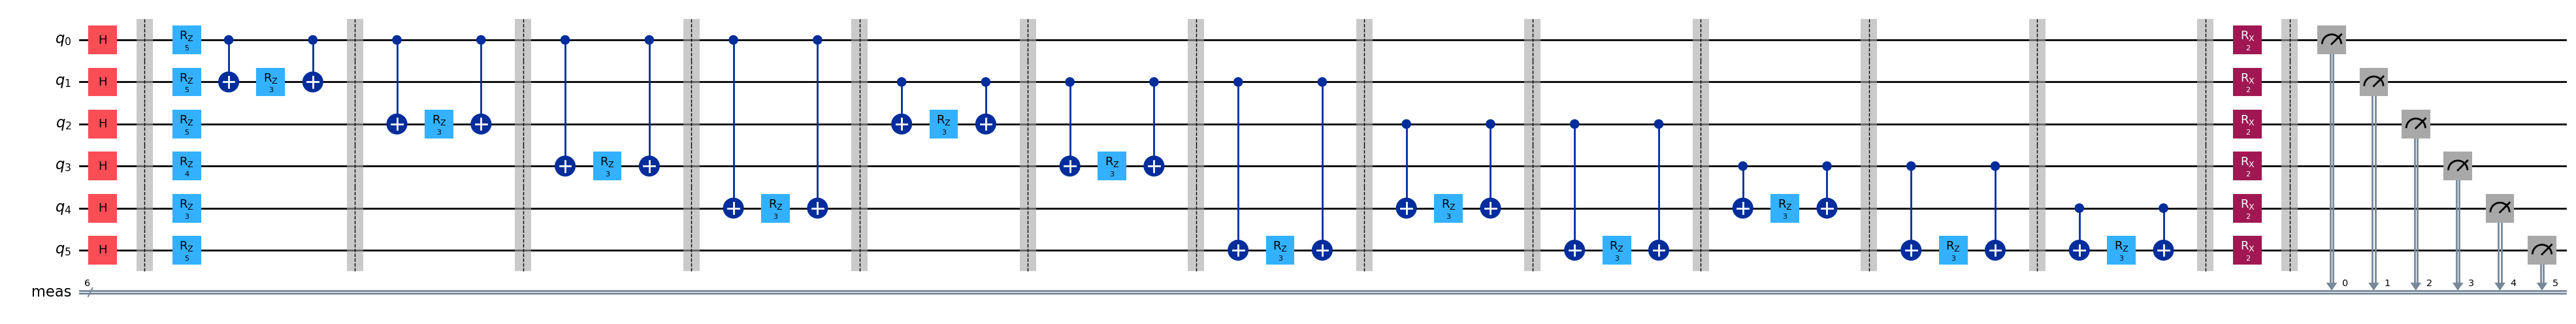

In [14]:
n_qubits = 6
qc = QuantumCircuit(n_qubits)

gamma = 1
beta = 1

for q in range(n_qubits):
    qc.h(q)

qc.barrier()

qc.rz(2*gamma*5/2, 0)
qc.rz(2*gamma*5/2, 1)
qc.rz(2*gamma*5/2, 2)
qc.rz(2*gamma*2,   3)
qc.rz(2*gamma*3/2, 4)
qc.rz(2*gamma*5/2, 5)

multiple_rz(qc, [0,1], 3/2, gamma, isBarrier=True)
multiple_rz(qc, [0,2], 3/2, gamma, isBarrier=True)
multiple_rz(qc, [0,3], 3/2, gamma, isBarrier=True)
multiple_rz(qc, [0,4], 3/2, gamma, isBarrier=True)

multiple_rz(qc, [1, 2], 3/2, gamma, isBarrier=True)
multiple_rz(qc, [1, 3], 3/2, gamma, isBarrier=True)
multiple_rz(qc, [1, 5], 3/2, gamma, isBarrier=True)

multiple_rz(qc, [2, 4], 3/2, gamma, isBarrier=True)
multiple_rz(qc, [2, 5], 3/2, gamma, isBarrier=True)

multiple_rz(qc, [3, 4], 3/2, gamma, isBarrier=True)
multiple_rz(qc, [3, 5], 3/2, gamma, isBarrier=True)

multiple_rz(qc, [4, 5], 3/2, gamma, isBarrier=True)

for q in range(n_qubits):
    qc.rx(2 * beta, q)

qc.measure_all()

qc.draw('mpl', fold=-1)

#### 3-b)

The same procedure applies to the switch-network encoding method.  
Based on the derived equations, the circuit for $p = 1$ can be drawn as follows.  

It can be observed that a total of 34 CNOT gates are used.

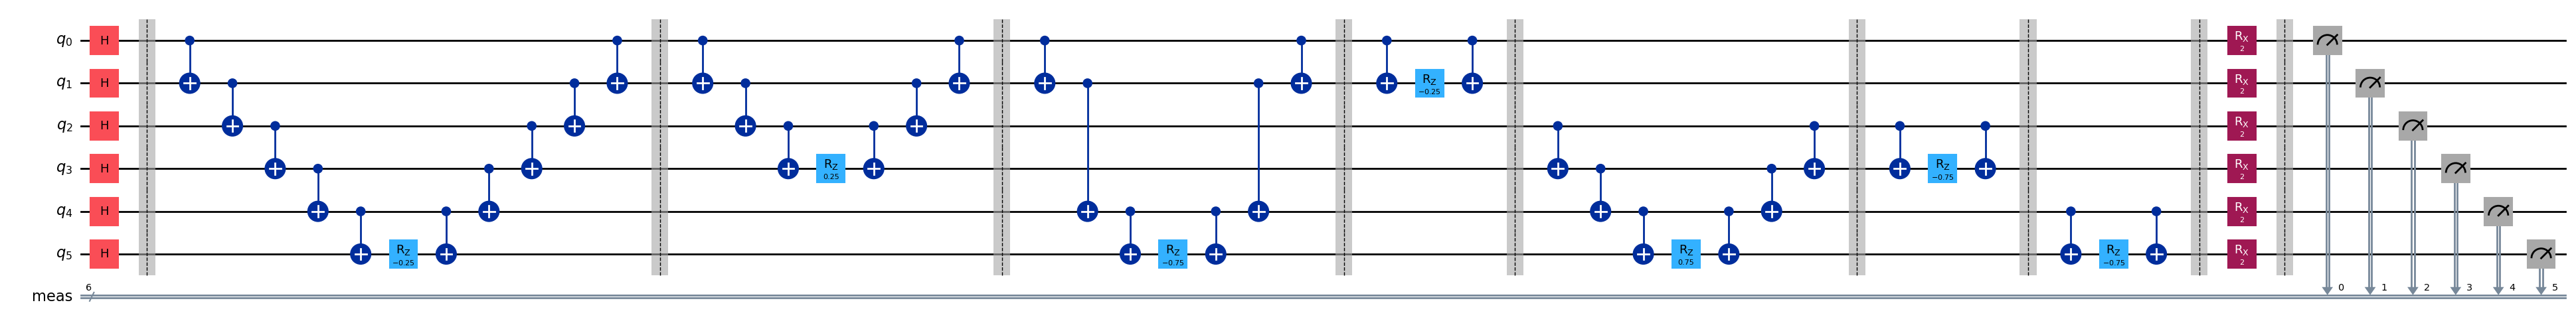

In [15]:
n_qubits = 6
qc2 = QuantumCircuit(n_qubits)

gamma = 1
beta = 1

for q in range(n_qubits):
    qc2.h(q)

qc2.barrier()

multiple_rz(qc2, [0,1,2,3,4,5], -1/8, gamma, isBarrier=True)
multiple_rz(qc2, [0,1,2,3], 1/8, gamma, isBarrier=True)
multiple_rz(qc2, [0,1,4,5], -3/8, gamma, isBarrier=True)
multiple_rz(qc2, [0,1], -1/8, gamma, isBarrier=True)
multiple_rz(qc2, [2,3,4,5], 3/8, gamma, isBarrier=True)
multiple_rz(qc2, [2,3], -3/8, gamma, isBarrier=True)
multiple_rz(qc2, [4,5], -3/8, gamma, isBarrier=True)


for q in range(n_qubits):
    qc2.rx(2 * beta, q)

qc2.measure_all()

qc2.draw('mpl', fold=-1)

#### Pre-prep : Define circuit generation function

Before solving Problems 3-c and 3-d, a function is defined to repeatedly construct the circuit by varying the value of $p$, which represents the number of repetitions of the Hamiltonian layers.

In [16]:
def gen_qaoa_leg(n_qubits, p, gammas, betas):
    qc = QuantumCircuit(n_qubits)
    for q in range(n_qubits):
        qc.h(q)
    qc.barrier()
    
    for layer in range(p):
        gamma = gammas[layer]
        beta = betas[layer]
        qc.rz(2*gamma*5/2, 0)
        qc.rz(2*gamma*5/2, 1)
        qc.rz(2*gamma*5/2, 2)
        qc.rz(2*gamma*2,   3)
        qc.rz(2*gamma*3/2, 4)
        qc.rz(2*gamma*5/2, 5)
        multiple_rz(qc, [0,1], 3/2, gamma)
        multiple_rz(qc, [0,2], 3/2, gamma)
        multiple_rz(qc, [0,3], 3/2, gamma)
        multiple_rz(qc, [0,4], 3/2, gamma)
        multiple_rz(qc, [1,2], 3/2, gamma)
        multiple_rz(qc, [1,3], 3/2, gamma)
        multiple_rz(qc, [1,5], 3/2, gamma)
        multiple_rz(qc, [2,4], 3/2, gamma)
        multiple_rz(qc, [2,5], 3/2, gamma)
        multiple_rz(qc, [3,4], 3/2, gamma)
        multiple_rz(qc, [3,5], 3/2, gamma)
        multiple_rz(qc, [4,5], 3/2, gamma)
        
        qc.barrier()
        for q in range(n_qubits):
            qc.rx(2 * beta, q)
            
    return qc

In [17]:
def gen_qaoa_switch(n_qubits, p, gammas, betas):
    qc = QuantumCircuit(n_qubits)

    for q in range(n_qubits):
        qc.h(q)
    qc.barrier()

    for layer in range(p):
        gamma = gammas[layer]
        beta = betas[layer]

        multiple_rz(qc, [0,1,2,3,4,5], -1/8, gamma)
        multiple_rz(qc, [0,1,2,3], 1/8, gamma)
        multiple_rz(qc, [0,1,4,5], -3/8, gamma)
        multiple_rz(qc, [0,1], -1/8, gamma)
        multiple_rz(qc, [2,3,4,5], 3/8, gamma)
        multiple_rz(qc, [2,3], -3/8, gamma)
        multiple_rz(qc, [4,5], -3/8, gamma)

        qc.barrier()
        for q in range(n_qubits):
            qc.rx(2 * beta, q)

    return qc

## 3-c) Leg variable encoding

Within the range of $p$ values such that the total number of CNOT gates does not exceed 3000, we need to find the value of $p$ that yields the maximum probability, along with the corresponding parameters.  
The parameters $\beta_i$ and $\gamma_i$ follow a linear trajectory across each layer $i$.  

In the leg-variable encoding method, each layer uses 24 CNOT gates.  
Therefore, the maximum possible value of $p$ is given by `3000 // 24 = 125`.

In [18]:
MAX_CNOT_N = 3000
LEG_CNOT_N = 24
p_max_leg = MAX_CNOT_N // LEG_CNOT_N

print(f'Max p: {p_max_leg}')

Max p: 125


Before performing the measurements, the theoretical values are first obtained using the `Statevector` simulation.  

After defining the objective function, the parameters are optimized while varying the value of $p$ to find the case where the target state (`101101`) has the highest probability.  

As a result of the optimization, the maximum probability of 0.270 for the state `101101` was achieved at $p = 92$, and the corresponding parameters were determined.

In [19]:
ground_state_bits = '101101'
ground_state_str_qiskit = ground_state_bits[::-1]

def objective_function_leg_statevector(params, p):
    gamma_start, gamma_end, beta_start, beta_end = params
    gammas = np.linspace(gamma_start, gamma_end, p)
    betas  = np.linspace(beta_start, beta_end, p)

    qc = gen_qaoa_leg(n_qubits, p, gammas, betas)

    sv = Statevector.from_instruction(qc)

    ground_index = int(ground_state_str_qiskit, 2)
    ground_probs = np.abs(sv.data[ground_index])**2

    return -ground_probs 

initial_params = [0, 2*np.pi, np.pi, 0]
results = []

for p in range(1, p_max_leg + 1):
    opt_result_leg = minimize(objective_function_leg_statevector,
                                initial_params,
                                args=(p,),
                                method='COBYLA',
                                options={'maxiter': 500, 'disp': False})
    
    gamma_start, gamma_end, beta_start, beta_end = opt_result_leg.x
    optimized_params = [gamma_start, gamma_end, beta_start, beta_end]
    max_prob = -opt_result_leg.fun
    results.append((p, optimized_params, max_prob))
    
best_p, best_params, best_prob = max(results, key=lambda x: x[2])
print(f'best p: {best_p} (prob={best_prob})')
print(f'best parameter: {best_params}')

best p: 92 (prob=0.26991868787861306)
best parameter: [np.float64(0.09114092190879439), np.float64(7.913526136392523), np.float64(4.584183530588206), np.float64(-0.7641200086051293)]


The result obtained using the optimized (theoretical) values is shown in the following figure.

 Prob: 0.269919


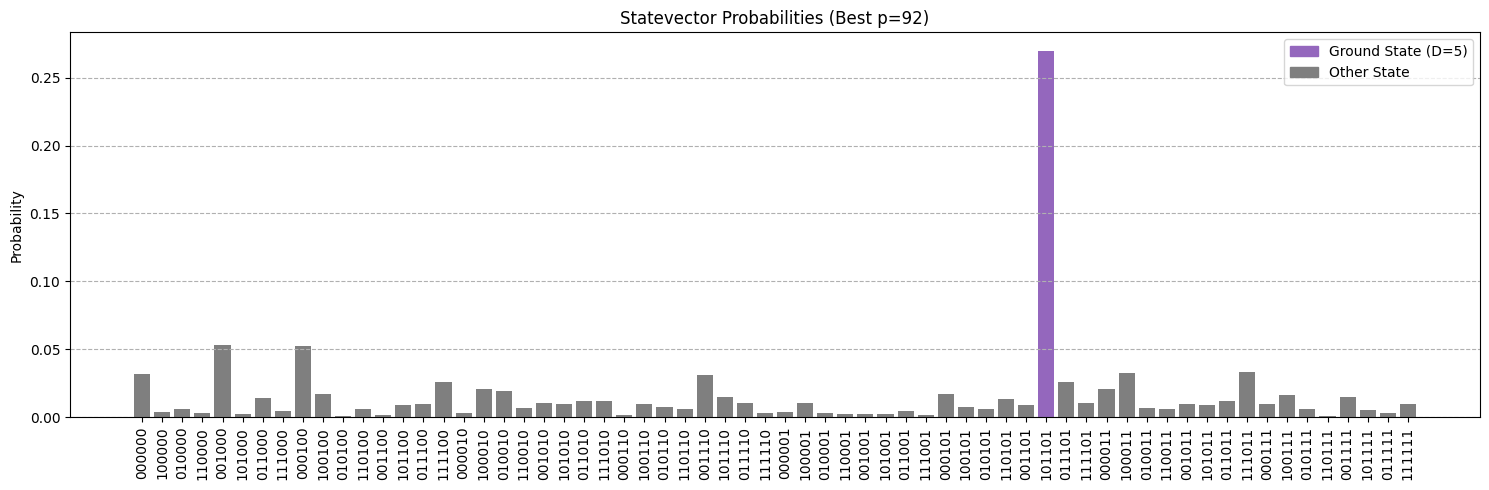

In [20]:
opt_gamma_start, opt_gamma_end, opt_beta_start, opt_beta_end = best_params

final_gammas = np.mod(np.linspace(opt_gamma_start, opt_gamma_end, best_p), np.pi*2)
final_betas  = np.mod(np.linspace(opt_beta_start, opt_beta_end, best_p), np.pi)

final_qc = gen_qaoa_leg(n_qubits, best_p, final_gammas, final_betas)
final_sv = Statevector.from_instruction(final_qc)

probs = np.abs(final_sv.data)**2
bitstrings = [format(i, f'0{n_qubits}b')[::-1] for i in range(2**n_qubits)]

target_index = bitstrings.index(ground_state_bits)
target_prob = probs[target_index]
print(f' Prob: {target_prob:.6f}')

# ---

colors = ['tab:purple' if b == ground_state_bits else 'tab:gray' for b in bitstrings]
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(bitstrings, probs, color=colors)
ax.set_ylabel('Probability')
ax.set_title(f'Statevector Probabilities (Best p={best_p})')
ax.tick_params(axis='x', labelrotation=90)
ax.grid(axis='y', linestyle='--')
purple_patch = mpatches.Patch(color='tab:purple', label='Ground State (D=5)')
gray_patch = mpatches.Patch(color='tab:gray', label='Other State')
ax.legend(handles=[purple_patch, gray_patch], loc='upper right', frameon=True)
plt.tight_layout()
plt.show()


Using the previously obtained $p$ value and the optimized parameters, the measurement is performed.  

The measurement results are found to be highly consistent with the theoretical values.

prob : 0.270361


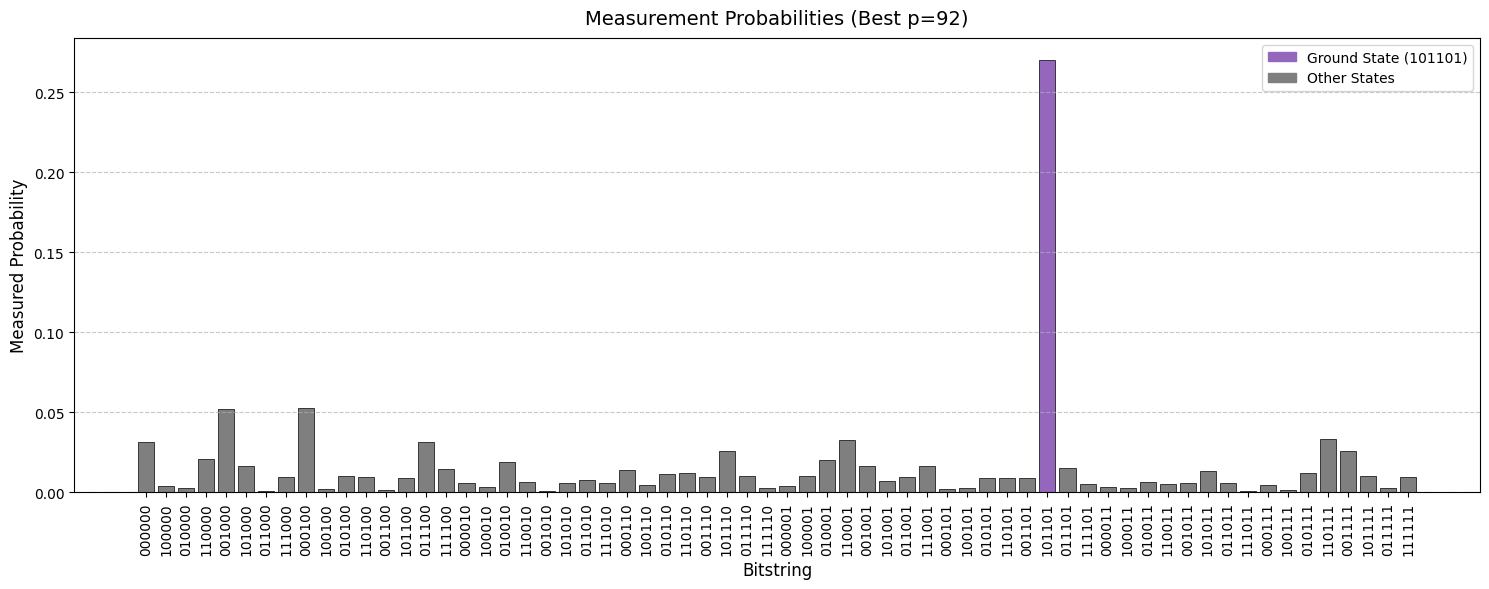

In [21]:
simulator = AerSimulator(max_parallel_threads=2)
p_leg_opt = best_p
n_shots = 1_000_000

gammas = np.mod(np.linspace(opt_gamma_start, opt_gamma_end, best_p), np.pi*2)
betas  = np.mod(np.linspace(opt_beta_start, opt_beta_end, best_p), np.pi)

leg_qc = gen_qaoa_leg(n_qubits, p_leg_opt, gammas, betas)
leg_qc.measure_all()

result_opt = simulator.run(leg_qc, shots =n_shots).result()
counts_opt = result_opt.get_counts()

bitstrings = [format(i, f'0{n_qubits}b')[::-1] for i in range(2**n_qubits)]

probs = np.array([counts_opt.get(b, 0) / n_shots for b in bitstrings])

print(f'prob : {counts_opt[ground_state_bits]/n_shots}')

# ---

colors = ['tab:purple' if b == ground_state_bits else 'tab:gray' for b in bitstrings]

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(bitstrings, probs, color=colors, edgecolor='black', linewidth=0.5)

ax.set_ylabel('Measured Probability', fontsize=12)
ax.set_xlabel('Bitstring', fontsize=12)
ax.set_title(f'Measurement Probabilities (Best p={best_p})', fontsize=14, pad=10)
ax.tick_params(axis='x', labelrotation=90)
ax.grid(axis='y', linestyle='--', alpha=0.7)

purple_patch = mpatches.Patch(color='tab:purple', label=f'Ground State ({ground_state_bits})')
gray_patch = mpatches.Patch(color='tab:gray', label='Other States')
ax.legend(handles=[purple_patch, gray_patch], loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

## 3-d)Switch network encoding

In the original switch-network encoding, a large number of qubits are entangled, resulting in the use of a considerable number of CNOT gates.  

Since excessive CNOT gates can introduce noise in physical quantum systems and may include redundant operations, it is beneficial to perform gate cancellation.  
This can be achieved by adjusting the `optimization_level` parameter in the `transpile` function.  

After simplification, the number of CNOT gates was successfully reduced to 22.

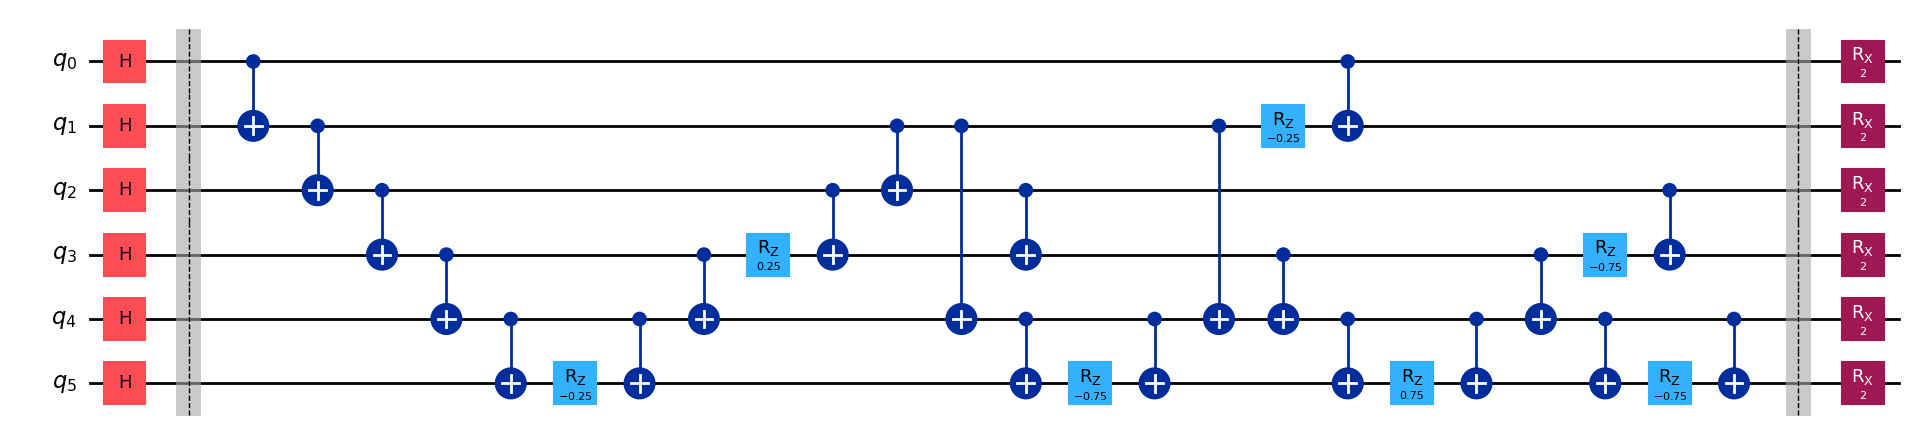

In [ ]:
optimized_qc2 = transpile(gen_qaoa_switch(n_qubits, 1, [1], [1]), optimization_level=1)

optimized_qc2.draw('mpl', fold=-1)

The same procedure is carried out based on the simplified circuit.  

First, by calculating the maximum possible value of $p$, it is found that $p_{\text{max}} = 136$.

In [23]:
MAX_CNOT_N = 3000
SWITCH_CNOT_N = 22
p_max_switch = MAX_CNOT_N // SWITCH_CNOT_N

print(f'Max p: {p_max_switch}')

Max p: 136


Similarly, the objective function is defined, and the theoretical values are first computed.  

In the leg-variable encoding, there was only one valid path with $D = 5$, so the optimization was performed based on a single target bitstring.  
However, as confirmed earlier, in this encoding method there are 24 valid paths with $D = 5$, and thus multiple solutions must be considered simultaneously.  

As a result of the optimization, the optimal value of $p$ was found to be 111, and the probability of obtaining $D = 5$ at this point was 0.981, indicating a very high success rate.

In [24]:
def objective_function_switch_statevector(params, p):
    gamma_start, gamma_end, beta_start, beta_end = params
    
    gammas = np.linspace(gamma_start, gamma_end, p)
    betas  = np.linspace(beta_start, beta_end, p)
    
    qc = gen_qaoa_switch(n_qubits, p, gammas, betas)
    transpile(qc, optimization_level=1)

    sv = Statevector.from_instruction(qc)
    
    ground_probs = 0
    for combo, dist in opt_combos:
        if dist == 5:
            bits = ''.join(map(str, combo))
            qiskit_bits = bits[::-1]
            idx = int(qiskit_bits, 2)
            ground_probs += np.abs(sv.data[idx])**2
    
    return -ground_probs

initial_params = [0, 2*np.pi, np.pi, 0]
results = []

for p in range(1, p_max_switch + 1):
    opt_result_switch = minimize(objective_function_switch_statevector,
                                initial_params,
                                args=(p,),
                                method='COBYLA',
                                options={'maxiter': 500, 'disp': False})
    
    gamma_start, gamma_end, beta_start, beta_end = opt_result_switch.x
    optimized_params = [gamma_start, gamma_end, beta_start, beta_end]
    max_prob = -opt_result_switch.fun
    results.append((p, optimized_params, max_prob))

best_p, best_params, best_prob = max(results, key=lambda x: x[2])
print(f'best p: {best_p} (prob={best_prob})')
print(f'best parameters: {best_params}')

best p: 111 (prob=0.9814513271228872)
best parameters: [np.float64(0.9962419282336845), np.float64(7.240133941138897), np.float64(3.1471181882867953), np.float64(0.02705814843544824)]


The theoretical values at this point are visualized in the following figure.

Prob: 0.981451


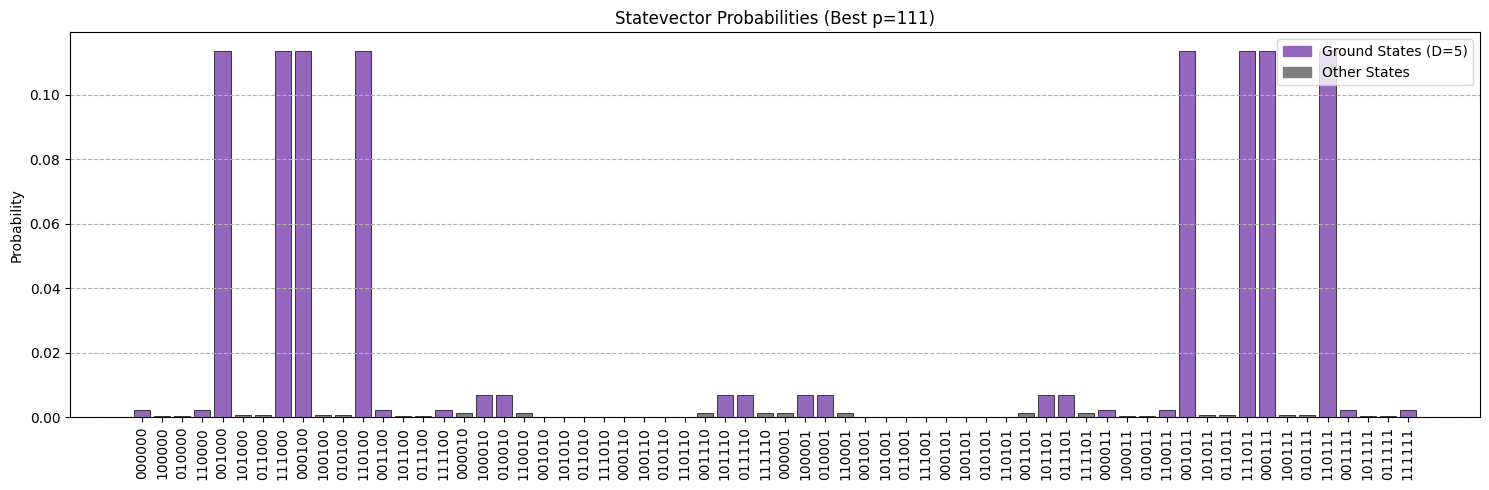

In [25]:
opt_gamma_start, opt_gamma_end, opt_beta_start, opt_beta_end = best_params

final_gammas = np.mod(np.linspace(opt_gamma_start, opt_gamma_end, best_p), 2*np.pi)
final_betas  = np.mod(np.linspace(opt_beta_start, opt_beta_end, best_p), np.pi)

final_qc = gen_qaoa_switch(n_qubits, best_p, final_gammas, final_betas)
transpile(final_qc, optimization_level=1)
final_sv = Statevector.from_instruction(final_qc)

probs = np.abs(final_sv.data)**2
bitstrings = [format(i, f'0{n_qubits}b')[::-1] for i in range(2**n_qubits)]

d5_states = [''.join(map(str, combo)) for combo, dist in opt_combos if dist == 5]
d5_states_qiskit = [s[::-1] for s in d5_states] 

total_ground_prob = sum(probs[bitstrings.index(s)] for s in d5_states_qiskit)
print(f'Prob: {total_ground_prob:.6f}')

# ---

colors = ['tab:purple' if b in d5_states else 'tab:gray' for b in bitstrings]
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(bitstrings, probs, color=colors, edgecolor='black', linewidth=0.5)
ax.set_ylabel('Probability')
ax.set_title(f'Statevector Probabilities (Best p={best_p})')
ax.tick_params(axis='x', labelrotation=90)
ax.grid(axis='y', linestyle='--')
purple_patch = mpatches.Patch(color='tab:purple', label='Ground States (D=5)')
gray_patch = mpatches.Patch(color='tab:gray', label='Other States')
ax.legend(handles=[purple_patch, gray_patch], loc='upper right', frameon=True)
plt.tight_layout()
plt.show()

Based on the parameters obtained above, the actual measurement is performed.  
The results, as shown below, closely match the theoretical values, confirming a high level of consistency between simulation and experiment.

prob: 0.981239


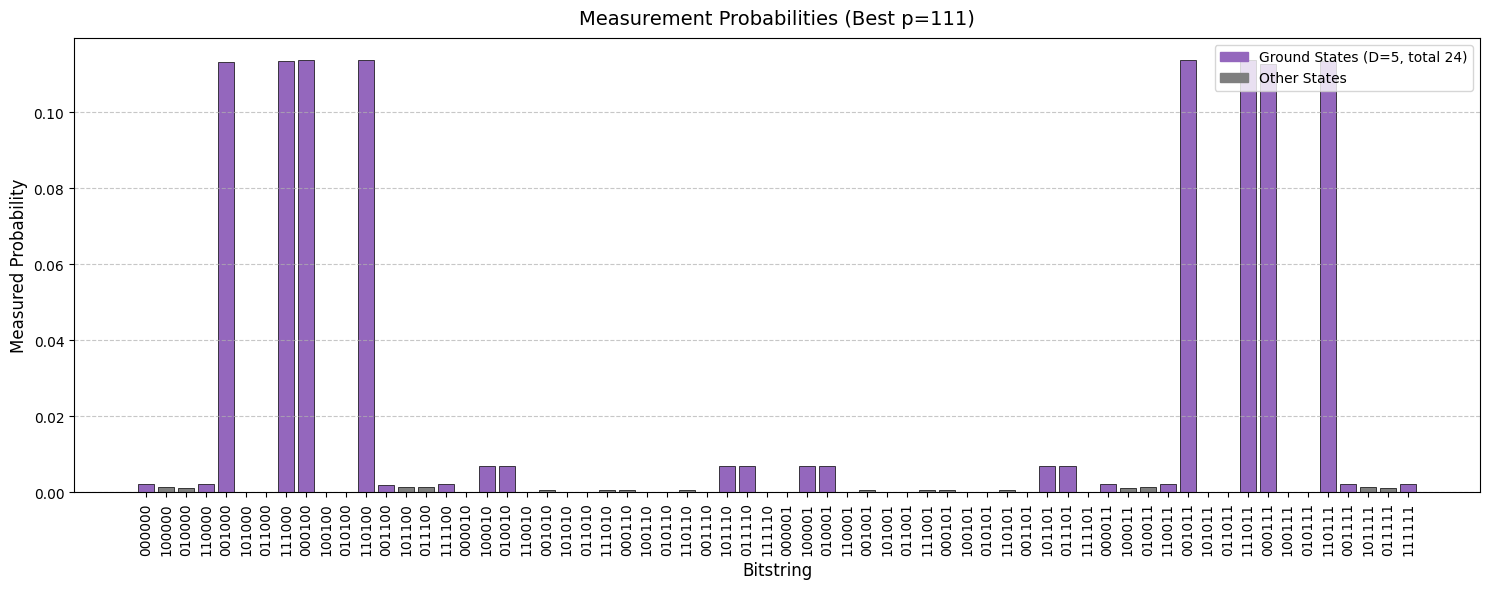

In [26]:
simulator = AerSimulator(max_parallel_threads=2)
p_switch_opt = best_p
n_shots = 1_000_000

gammas = np.mod(np.linspace(opt_gamma_start, opt_gamma_end, best_p), np.pi*2)
betas  = np.mod(np.linspace(opt_beta_start, opt_beta_end, best_p), np.pi)

switch_qc = gen_qaoa_switch(n_qubits, p_switch_opt, gammas, betas)
switch_qc.measure_all()

result_opt = simulator.run(switch_qc, shots=n_shots).result()
counts_opt = result_opt.get_counts()

bitstrings = [format(i, f'0{n_qubits}b')[::-1] for i in range(2**n_qubits)]

probs = np.array([counts_opt.get(b, 0) / n_shots for b in bitstrings])

d5_states = [''.join(map(str, combo)) for combo, dist in opt_combos if dist == 5]
d5_states_qiskit = [s[::-1] for s in d5_states] 

total_ground_prob = sum(counts_opt.get(state, 0) for state in d5_states_qiskit) / n_shots
print(f'prob: {total_ground_prob:.6f}')

# ---

colors = ['tab:purple' if b in d5_states_qiskit else 'tab:gray' for b in bitstrings]

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(bitstrings, probs, color=colors, edgecolor='black', linewidth=0.5)

ax.set_ylabel('Measured Probability', fontsize=12)
ax.set_xlabel('Bitstring', fontsize=12)
ax.set_title(f'Measurement Probabilities (Best p={best_p})', fontsize=14, pad=10)
ax.tick_params(axis='x', labelrotation=90)
ax.grid(axis='y', linestyle='--', alpha=0.7)


purple_patch = mpatches.Patch(color='tab:purple', label='Ground States (D=5, total 24)')
gray_patch = mpatches.Patch(color='tab:gray', label='Other States')
ax.legend(handles=[purple_patch, gray_patch], loc='upper right', frameon=True)

plt.tight_layout()
plt.show()


## Conclusion

Through this series of processes, it was found that the leg-variable encoding produces a simpler circuit but has a highly restricted solution space, whereas the switch-network encoding results in a more complex circuit while encompassing a larger number of valid solutions.  
Therefore, the appropriate encoding method should be chosen depending on the problem context.  

In this particular problem, since only four cities were considered, a classical computer can solve it more efficiently.  
However, as the number of cities increases and the computational cost on classical systems grows exponentially, quantum computing approaches such as QAOA become significantly more advantageous.